In [1538]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from linearmodels import PanelOLS
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm

In [1539]:
file_path = "cleaned_dataset.csv"  # Укажите путь к вашему CSV-файлу
df = pd.read_csv(file_path, na_values=[''])

In [1540]:
def cumulative_technologies(group):
    cumulative = set()  # Используем множество для хранения уникальных технологий
    result = []
    tech_years = {}  # Словарь для хранения года внедрения каждой технологии

    for year, tech in group.items():  # Используем .items() вместо .iteritems()
        if tech:  # Игнорируем пустые строки
            # Разделяем строку на отдельные технологии по запятым
            technologies = [t.strip() for t in tech.split(',')]
            for t in technologies:
                tech_years[t] = year  # Запоминаем год внедрения технологии
                cumulative.add(t)

        # Удаляем технологии, срок действия которых истек (более 3 лет назад)
        current_year = year
        cumulative = {t for t in cumulative if current_year - tech_years[t] <= 3}

        # Объединяем уникальные технологии в строку с разделителем запятая
        result.append(', '.join(sorted(cumulative)))  # Сортируем для удобства

    return result

In [1541]:
# Заполняем пропущенные значения в столбце 'Технология' пустой строкой
df['Технология'] = df['Технология'].fillna('')

# Сортируем данные по компании и году
df = df.sort_values(by=['Компания', 'year'])

# Применяем функцию к каждой группе
df['Кумулятивные_технологии'] = df.groupby('Компания')['Технология'].transform(cumulative_technologies)

In [1542]:
df['techdm'] = df['Кумулятивные_технологии'].apply(lambda x: 1 if x else 0)

In [1543]:
# Calculate the foundation year for each company
df['Год_основания'] = df.groupby('Компания')['year'].transform('min')

# Calculate the age of the company
df['age'] = df['year'] - df['Год_основания']

In [1544]:
df.columns

Index(['Компания', 'Город', 'name', 'region.y', 'industry', 'size_cat',
       'employees', 'income', 'expenses', 'receivables', 'assets', 'passive',
       'nwc', 'equity', 'total_debt', 'sales', 'cgs', 'commercial', 'ebt',
       'eat', 'ebit', 'labor_costs', 'net_profit_margin', 'ros', 'year',
       'code_okved', 'firts_number_okved', 'ind', 'Продукт', 'Технология',
       'Кумулятивные_технологии', 'techdm', 'Год_основания', 'age'],
      dtype='object')

---
Строю регрессию тут

In [1545]:
# Преобразование строки технологий в список и подсчет количества
df['Количество_технологий'] = df['Кумулятивные_технологии'].apply(
    lambda x: len(set(x.split(', '))) if x else 0
)

In [1546]:
# df['year_index'] = df['year']

In [1547]:
# # Dummy для года
# df = pd.get_dummies(df, columns=['year'], prefix='Year')

# # Dummy для отрасли (ind)
# df = pd.get_dummies(df, columns=['ind'], prefix='Industry')

# # Dummy для размера компании (size_cat)
# df = pd.get_dummies(df, columns=['size_cat'], prefix='Size')

In [1548]:
df = df.set_index(['Компания', 'year'])

In [1549]:
# Зависимая переменная
y = df['eat']

# Независимые переменные: количество технологий и dummy-переменные
# X = df[['Количество_технологий']]
X = df[['Количество_технологий', 'employees']]
X = X.join(pd.get_dummies(df['size_cat'], prefix='Size', drop_first=True))
# Добавляем финансовые показатели в качестве контрольных переменных
financial_controls = ['total_debt', 'sales', 'cgs', 'labor_costs']
X = X.join(df[financial_controls])

In [1550]:
df.columns

Index(['Город', 'name', 'region.y', 'industry', 'size_cat', 'employees',
       'income', 'expenses', 'receivables', 'assets', 'passive', 'nwc',
       'equity', 'total_debt', 'sales', 'cgs', 'commercial', 'ebt', 'eat',
       'ebit', 'labor_costs', 'net_profit_margin', 'ros', 'code_okved',
       'firts_number_okved', 'ind', 'Продукт', 'Технология',
       'Кумулятивные_технологии', 'techdm', 'Год_основания', 'age',
       'Количество_технологий'],
      dtype='object')

In [1551]:
df['log_sales'] = np.log1p(df['sales'])
df['log_cgs'] = np.log1p(df['cgs'])
df['log_eat'] = np.log1p(df['eat'])
df['log_ebit'] = np.log1p(df['ebit'])
df['log_ebt'] = np.log1p(df['ebt'])
df['log_td'] = np.log1p(df['total_debt'])
df['log_lc'] = np.log1p(df['labor_costs'])
df['log_nwc'] = np.log1p(df['nwc'])
df['log_assets'] = np.log1p(df['assets'])
df['log_eq'] = np.log1p(df['equity'])
df['log_rec'] = np.log1p(df['receivables'])
df['lag_tech'] = df.groupby(level='Компания')['Количество_технологий'].shift(1)

c:\Users\Home\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Home\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Home\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Home\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\Users\Home\AppData\Local\Programs\Python\Python313\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufun

In [1552]:
print(f"Количество строк в y: {len(y)}")
print(f"Количество строк в X: {len(X)}")

Количество строк в y: 4264
Количество строк в X: 4636


In [1553]:
df['employees'] = df.groupby('Компания')['employees'].fillna(method='bfill')
df['log_empl'] = np.log1p(df['employees'])


C:\Users\Home\AppData\Local\Temp\ipykernel_18884\107979903.py:1: FutureWarning: SeriesGroupBy.fillna is deprecated and will be removed in a future version. Use obj.ffill() or obj.bfill() for forward or backward filling instead. If you want to fill with a single value, use Series.fillna instead
  df['employees'] = df.groupby('Компания')['employees'].fillna(method='bfill')
C:\Users\Home\AppData\Local\Temp\ipykernel_18884\107979903.py:1: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['employees'] = df.groupby('Компания')['employees'].fillna(method='bfill')


In [1554]:
list(df.columns)

['Город',
 'name',
 'region.y',
 'industry',
 'size_cat',
 'employees',
 'income',
 'expenses',
 'receivables',
 'assets',
 'passive',
 'nwc',
 'equity',
 'total_debt',
 'sales',
 'cgs',
 'commercial',
 'ebt',
 'eat',
 'ebit',
 'labor_costs',
 'net_profit_margin',
 'ros',
 'code_okved',
 'firts_number_okved',
 'ind',
 'Продукт',
 'Технология',
 'Кумулятивные_технологии',
 'techdm',
 'Год_основания',
 'age',
 'Количество_технологий',
 'log_sales',
 'log_cgs',
 'log_eat',
 'log_ebit',
 'log_ebt',
 'log_td',
 'log_lc',
 'log_nwc',
 'log_assets',
 'log_eq',
 'log_rec',
 'lag_tech',
 'log_empl']

In [1555]:
if len(y) != len(X):
    print(df.index.duplicated().sum())
    duplicates = df[df.index.duplicated(keep=False)]
    df = df[~df.index.duplicated(keep='last')]
    y = df['log_sales']
    # X = df[['techdm']].join(pd.get_dummies(df['size_cat'], prefix='Size', drop_first=True))
    X = df[['Количество_технологий']].join(pd.get_dummies(df['size_cat'], prefix='Size', drop_first=True))
    financial_controls = ['log_rec']
    X = X.join(df[financial_controls])
    print(f"Количество строк в y: {len(y)}")
    print(f"Количество строк в X: {len(X)}")
else:
    print("Нет дубликатов")

47
Количество строк в y: 4217
Количество строк в X: 4217


In [1556]:
# X — матрица предикторов без категориальных переменных
X_numerical = df[['Количество_технологий', 'assets',
 'passive',
 'nwc',
 'equity',
 'total_debt',
 'sales',
 'cgs',
 'commercial',
 'eat',
 'ebit',
 'labor_costs',
 'net_profit_margin',
 'ros',]]

# Добавляем константу для корректности расчетов
X_numerical = sm.add_constant(X_numerical)
X_numerical = X_numerical.dropna()

# Рассчитываем VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = X_numerical.columns
vif_data["VIF"] = [variance_inflation_factor(X_numerical.values, i) for i in range(X_numerical.shape[1])]

print(vif_data)


                  Feature       VIF
0                   const      3.40
1   Количество_технологий      1.02
2                  assets 568142.20
3                 passive 568308.66
4                     nwc      1.97
5                  equity     69.07
6              total_debt     76.17
7                   sales     42.25
8                     cgs     30.82
9              commercial      2.86
10                    eat      2.21
11                   ebit      2.62
12            labor_costs      1.49
13      net_profit_margin      2.38
14                    ros      1.38


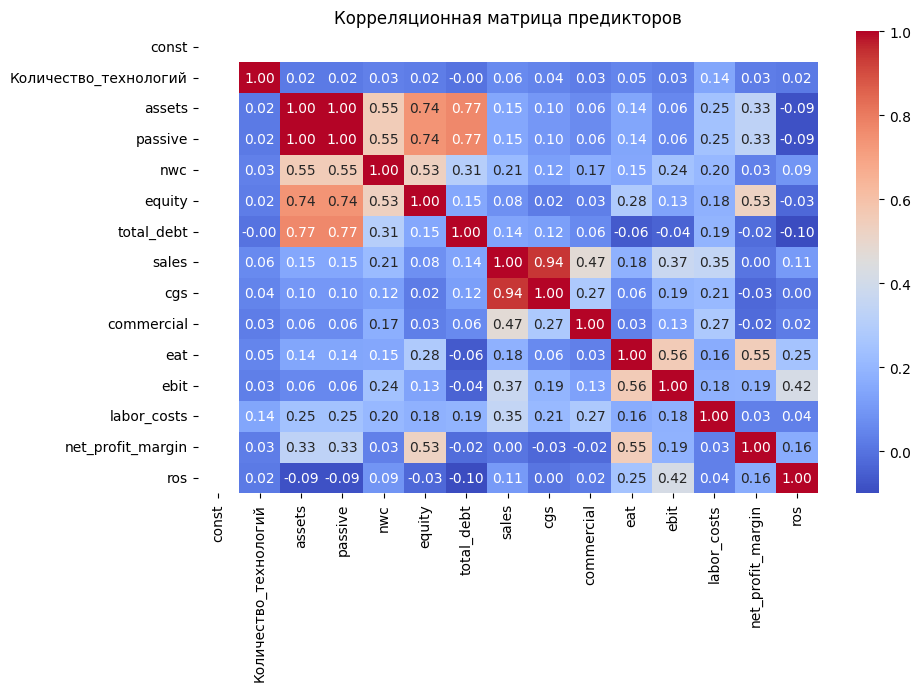

In [1557]:
import seaborn as sns

corr_matrix = X_numerical.corr()

# Визуализация
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Корреляционная матрица предикторов")
plt.show()


In [1558]:
# Проверка пропущенных значений в y
print(f"Пропущенные значения в y: {y.isnull().sum()}")

# Проверка пропущенных значений в X
print(f"Пропущенные значения в X: {X.isnull().sum()}")

Пропущенные значения в y: 1
Пропущенные значения в X: Количество_технологий       0
Size_Средние предприятия    0
log_rec                     4
dtype: int64


In [1559]:
df.columns

Index(['Город', 'name', 'region.y', 'industry', 'size_cat', 'employees',
       'income', 'expenses', 'receivables', 'assets', 'passive', 'nwc',
       'equity', 'total_debt', 'sales', 'cgs', 'commercial', 'ebt', 'eat',
       'ebit', 'labor_costs', 'net_profit_margin', 'ros', 'code_okved',
       'firts_number_okved', 'ind', 'Продукт', 'Технология',
       'Кумулятивные_технологии', 'techdm', 'Год_основания', 'age',
       'Количество_технологий', 'log_sales', 'log_cgs', 'log_eat', 'log_ebit',
       'log_ebt', 'log_td', 'log_lc', 'log_nwc', 'log_assets', 'log_eq',
       'log_rec', 'lag_tech', 'log_empl'],
      dtype='object')

In [1560]:
# Модель с фиксированными эффектами
model = PanelOLS(y, X, entity_effects=True, time_effects=True, drop_absorbed=True)
pd.options.display.float_format = '{:.2f}'.format
# Выполняем модель и выводим результаты
results = model.fit(cov_type='clustered', cluster_entity=True)
print(results.summary)

                          PanelOLS Estimation Summary                           
Dep. Variable:              log_sales   R-squared:                        0.2630
Estimator:                   PanelOLS   R-squared (Between):              0.6388
No. Observations:                4212   R-squared (Within):               0.3357
Date:                 Чт, мар 20 2025   R-squared (Overall):              0.6384
Time:                        18:59:08   Log-likelihood                   -2881.9
Cov. Estimator:             Clustered                                           
                                        F-statistic:                      431.90
Entities:                         568   P-value                           0.0000
Avg Obs:                       7.4155   Distribution:                  F(3,3631)
Min Obs:                       4.0000                                           
Max Obs:                       11.000   F-statistic (robust):             63.015
                            

c:\Users\Home\AppData\Local\Programs\Python\Python313\Lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


In [1561]:
from linearmodels.panel import RandomEffects
from scipy.stats import chi2

In [1562]:
fe_model = PanelOLS(y, X, entity_effects=True).fit()

c:\Users\Home\AppData\Local\Programs\Python\Python313\Lib\site-packages\linearmodels\panel\model.py:1260: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


In [1563]:
re_model = RandomEffects(y, X).fit()

c:\Users\Home\AppData\Local\Programs\Python\Python313\Lib\site-packages\linearmodels\panel\model.py:2759: MissingValueWarning: 
Inputs contain missing values. Dropping rows with missing observations.
  super().__init__(dependent, exog, weights=weights, check_rank=check_rank)


In [1564]:
b_fe = fe_model.params
b_re = re_model.params
diff = b_fe - b_re

In [1565]:
V_fe = fe_model.cov
V_re = re_model.cov
V_diff = V_fe - V_re

In [1566]:
chi2_stat = diff.T @ np.linalg.inv(V_diff) @ diff
p_value = 1 - chi2.cdf(chi2_stat, df=len(diff))

In [1567]:
print(f'Hausman test statistic: {chi2_stat:.4f}')
print(f'P-value: {p_value:.4f}')

Hausman test statistic: 2601.1239
P-value: 0.0000
